In [1]:
# basics
import pandas as pd
import numpy as np
import itertools
import random
import pickle

# vectorizer, classifiers, and metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, confusion_matrix, jaccard_score, hamming_loss, log_loss
from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.model_selection.iterative_stratification import iterative_train_test_split
from sklearn.model_selection import GridSearchCV

# rnn
import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

from gensim.models import KeyedVectors

# custom functions, class to import and process data
from get_labeled_dfs import *
from process_text import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# use custom function to get the corpus df and labels 
corpus_df, emotion_df, valence_df = get_labeled_dfs()


In [3]:
# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)


In [4]:
# after processing, the text in the corpus df is all lower case, free of punctuation (except emotion-relevant exclamation points and question marks), 
# free of numbers, and lemmatized
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,hussein ally hang iraqi official
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [5]:
# The emotion df contains ratings for each emotion, the max rating, and label columns 
# for each emotion with a 1 indicating that the emotion is present (it has a non-zero 
# rating) or a 0 indicating that it is not.  
emotion_df.head()

,anger,disgust,fear,joy,sadness,suprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,suprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


In [6]:
def label_confusion_matrices(lst, df, RNN=False):
    
    '''A function that creates confusion matrices and calculates accuracy, precision, 
    recall, and f1 for each individual label'''
    
    plt.figure(figsize=(15,10))
    subplot_num = 1

    for i in lst:
        
        if RNN==False:
        
            tp = len(df.loc[(df['pred_' + i]==1) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]==1) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]==0) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]==0) & (df[i]==0)])
        
        else:
            
            tp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==0)])
        
        
        plt.subplot(2,3,subplot_num)
        sns.heatmap([[tp, fp], [tn, fn]], square=True, annot=True, fmt='g', yticklabels=[i, 'not ' + i], xticklabels=[i, 'not ' + i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(i.capitalize() + ' Confusion Matrix')
        subplot_num+=1
        
        accuracy = tp/(fp + tn + tp + fn)
        precision = tp/(fp + tp)
        recall = tp/(tp + fn)
        f1 = 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn))))
        
        print(i + " accuracy:", accuracy)
        print(i + " precision:", precision)
        print(i + " recall", recall)
        print(i + " f1", 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn)))))
        print('\n')

        

In [7]:
def suite_of_scores(y_true, y_pred):
    
    '''A function that calculates jaccard similarity, hamming loss, f1 macro, 
    and log loss to assess the model's overall performance'''
    
    jaccard_score_micro = jaccard_score(y_true, y_pred, average='micro')
    hamming_loss_score = hamming_loss(y_true, y_pred)
    f1_macro_score = f1_score(y_true, y_pred, average='macro')
    
    print('jaccard score micro:', round(jaccard_score_micro, 3))
    print('hamming loss:', round(hamming_loss_score, 3))
    print('f1 macro:', round(f1_macro_score, 3))
    

In [8]:
# create vectors
word2vec = KeyedVectors.load_word2vec_format('/Users/flatironschool/Desktop/Detecting_Emotions/data/GoogleNews-vectors-negative300.bin', \
        binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

Found 3000000 word vectors of word2vec


In [9]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(corpus_df['text']))

In [10]:
# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(corpus_df['text'])

# add zeros to the front of each sequence as necessary to make them all the same length
padded_data = sequence.pad_sequences(sequences, maxlen=15, padding='post')


In [11]:
# get the data into a 3 dimensional array: number of sentences by max words per sentence (15) by shape of vectors (300)
reshape = padded_data.reshape(18750,1)
zeros = np.zeros((18750, 300))
concatenated = np.concatenate((reshape, zeros), axis=1)
sentence_df = pd.DataFrame(concatenated)

# add the vecors to the dataframe corresponding to the word sequence numbers

for i in range(len(sentence_df)):
    word = sentence_df.loc[i, 0]
    try:
        vec = word2vec[tokenizer.index_word[word]]
        sentence_df.iloc[i, 1:] = vec
    except:
        pass
    


In [12]:
data_matrix = np.array(sentence_df.iloc[:, 1:]).reshape(-1, 15, 300)


In [13]:
data_matrix[data_matrix == 0] = np.nan
mean_sentence_vec = np.nanmean(data_matrix, axis=1)
mean_sentence_vec = np.nan_to_num(mean_sentence_vec)

In [14]:
random.seed(22)
# first split the data into separate training and testing sets using an iterative_train_test_split
# to ensure that labels are distributed as evenly as possibile between the training and test sets
X_train, y_train, X_test, y_test = iterative_train_test_split(mean_sentence_vec, emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'suprise_label']].values, test_size=.25)


## One Versus Rest Model

An important consideration in choosing a multilabel prediction model is whether the labels are independent or correlated. There is some moderate correlation between the labels in my dataset.

*Insert pic*

For comparison, I tested methods that treats labels as independent and methods that allows for label correlations. In this notebook, I include:

* One Versus Rest Classifier

A One Versus Rest classifier trains a separate model for each label in the dataset. Each model's predictions are independent of al the others.

For this model, I used a logistic regression classifier.

* Correlated: Chain Classifier

A Chain Classifier trains a model for each label in the dataset, but each model's predictions are transferred to the next model, so the probabistic relationships between labels are taken into account.

For this model, I used a linear support vector classifier.

Chain Classifiers are sensitive to label order, so I tested all 750 possible label orders to find the best one. If my dataset were significantly larger or if I had significantly more label combinations to tested, it would have been too computationally expensive, and thus more practical to do a random selection of label orders to test. 

The Chain Classifier model did have a slight advantage over the One Versus Rest model. 


In [16]:
# lr = LogisticRegression()

# parameters = {
#     'estimator__penalty': ['l1', 'l2'],
#     'estimator__C': [.001, .01, .1, 1, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10],
#     'estimator__class_weight': ['balanced', None]
# }

# clf = GridSearchCV(OneVsRestClassifier(lr), parameters, scoring = '', cv=5)
# clf.fit(X_train, y_train)

# print(clf.best_params_, clf.best_score_)

# ovr = clf.best_estimator_.fit(X_train, y_train)
# ovr_test_preds = ovr.predict(X_test)

In [15]:
svc = SVC(class_weight='balanced')

parameters = {
    'estimator__kernel':['rbf', 'poly', 'sigmoid'],
    'estimator__C': [.001, .1, 1, 10, 100],
    'estimator__degree': [3, 4],
    'estimator__coef0': [0.1, 0.5, 1, 1.5],
    'estimator__gamma': [0.1, .05, 1],
}

clf = GridSearchCV(OneVsRestClassifier(svc), parameters, scoring = 'jaccard_micro', cv=5, n_jobs=3)
clf.fit(X_train, y_train)

print(clf.best_params_, clf.best_score_)

svc = clf.best_estimator_.fit(X_train, y_train)
svc_test_preds = svc.predict(X_test)

{'estimator__C': 100, 'estimator__coef0': 0.1, 'estimator__degree': 3, 'estimator__gamma': 1, 'estimator__kernel': 'rbf'} 0.6936598802714838


In [16]:
svc_preds_df = pd.DataFrame(svc_test_preds, columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
y_test_df = pd.DataFrame(y_test, columns=['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'])
svc_preds_df = pd.concat([svc_preds_df, y_test_df], axis=1)

anger_label accuracy: 0.40460526315789475
anger_label precision: 0.8913043478260869
anger_label recall 0.7454545454545455
anger_label f1 0.8118811881188119


disgust_label accuracy: 0.24671052631578946
disgust_label precision: 0.8152173913043478
disgust_label recall 0.5681818181818182
disgust_label f1 0.6696428571428572


fear_label accuracy: 0.5986842105263158
fear_label precision: 0.7844827586206896
fear_label recall 0.900990099009901
fear_label f1 0.8387096774193549


joy_label accuracy: 0.5855263157894737
joy_label precision: 0.7385892116182573
joy_label recall 0.9081632653061225
joy_label f1 0.8146453089244852


sadness_label accuracy: 0.6348684210526315
sadness_label precision: 0.7751004016064257
sadness_label recall 0.946078431372549
sadness_label f1 0.8520971302428255


surprise_label accuracy: 0.8848684210526315
surprise_label precision: 0.8966666666666666
surprise_label recall 0.992619926199262
surprise_label f1 0.9422066549912435




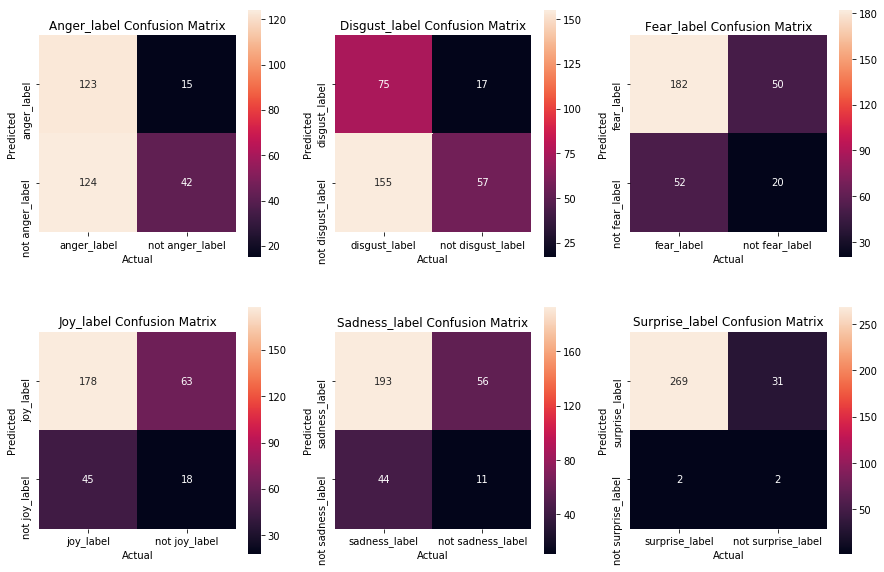

In [17]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], svc_preds_df)


In [18]:
suite_of_scores(y_test, svc_test_preds)


jaccard score micro: 0.728
hamming loss: 0.209
f1 macro: 0.822


In [20]:
# filename = 'svm_ovr.sav'
#  pickle.dump(svc, open(filename, 'wb'))

## Classifier Chain

In [21]:
random.seed(22)
svc = SVC(class_weight='balanced')

perms = list(itertools.permutations([0,1,2,3,4,5]))
perms_list = np.random.choice(range(len(perms)), size=10, replace=False)

parameters = {
    'order': [perms[i] for i in perms_list],
    'classifier__kernel':['rbf', 'poly'],
    'classifier__C': [.001, .1, 1, 10, 100],
    'classifier__degree': [3, 4],
    'classifier__coef0': [0.1, 0.5, 1, 1.5],
    'classifier__gamma': [0.1, .05, 1],
}

clf = GridSearchCV(ClassifierChain(svc), parameters, scoring = 'jaccard_micro', cv=5, n_jobs=3)
clf.fit(X_train, y_train)

print(clf.best_params_, clf.best_score_)


# chains = [ClassifierChain(svc, order=perms[i]) for i in range(720)]

# results_jaccard = []
# preds = []
# for chain in chains:
#     chain.fit(X_train, y_train)
#     test_preds = chain.predict(X_test)
#     preds.append(test_preds)
#     results_jaccard.append(jaccard_score(y_test, test_preds, average='micro'))


{'classifier__C': 1, 'classifier__coef0': 0.1, 'classifier__degree': 3, 'classifier__gamma': 1, 'classifier__kernel': 'rbf', 'order': (0, 2, 1, 3, 4, 5)} 0.6420680320099922


In [26]:
cc = clf.best_estimator_.fit(X_train, y_train)
cc_test_preds = cc.predict(X_test)

# cc_test_preds = preds[results_jaccard.index(max(results_jaccard))]
# max(results_jaccard)

In [27]:
cc_preds_df = pd.DataFrame(cc_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
cc_preds_df = pd.concat([cc_preds_df, y_test_df], axis=1)

anger_label accuracy: 0.3881578947368421
anger_label precision: 0.8939393939393939
anger_label recall 0.7151515151515152
anger_label f1 0.7946127946127947


disgust_label accuracy: 0.3618421052631579
disgust_label precision: 0.5583756345177665
disgust_label recall 0.8333333333333334
disgust_label f1 0.6686930091185411


fear_label accuracy: 0.3618421052631579
fear_label precision: 0.8870967741935484
fear_label recall 0.5445544554455446
fear_label f1 0.6748466257668712


joy_label accuracy: 0.47039473684210525
joy_label precision: 0.7409326424870466
joy_label recall 0.7295918367346939
joy_label f1 0.7352185089974292


sadness_label accuracy: 0.555921052631579
sadness_label precision: 0.8366336633663366
sadness_label recall 0.8284313725490197
sadness_label f1 0.832512315270936


surprise_label accuracy: 0.868421052631579
surprise_label precision: 0.8949152542372881
surprise_label recall 0.974169741697417
surprise_label f1 0.9328621908127209




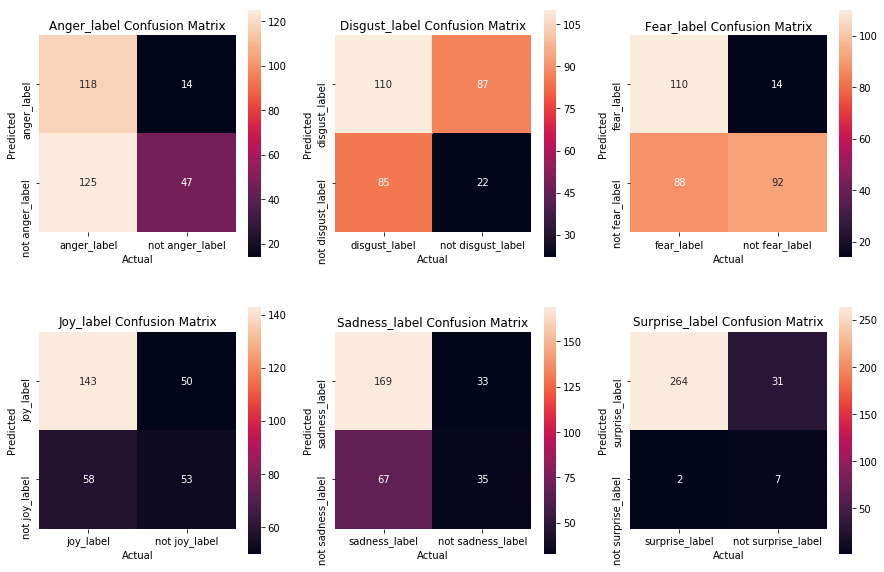

In [28]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], cc_preds_df)



In [29]:
suite_of_scores(y_test, cc_test_preds.toarray())


jaccard score micro: 0.653
hamming loss: 0.266
f1 macro: 0.773


## RNN for Multilabel Classification

In [30]:
# use custom function to get the corpus df and labels 
corpus_df_RNN, _, _ = get_labeled_dfs()

# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df_RNN, RNN=True)


In [31]:
# create vectors
word2vec = KeyedVectors.load_word2vec_format('/Users/flatironschool/Desktop/Detecting_Emotions/data/GoogleNews-vectors-negative300.bin', \
        binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(corpus_df_RNN['text']))

# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(corpus_df_RNN['text'])

# add zeros to the front of each sequence as necessary to make them all the same length
padded_data = sequence.pad_sequences(sequences, maxlen=15, padding='post')

            

Found 3000000 word vectors of word2vec


In [32]:
# create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# fill the array so that the word vectors that fill the array correspond to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in word2vec.vocab.keys():
        embedding_matrix[ind + 1, :] = word2vec[word]
        


In [33]:
random.seed(99)
X_train, y_train, X_test, y_test = iterative_train_test_split(padded_data, emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'suprise_label']].values, test_size=.25)

# labels multihot encoded
# y_train_multihot = y_train.values
# y_test_multihot = y_test.values


In [34]:
# Check to see that the labels are evenly divided
print('Percent of each label appreaing in the test set')
print("   Anger:", y_test[:,0].sum()/y_train[:,0].sum())
print("   Disgust:", y_test[:,1].sum()/y_train[:,1].sum())
print("   Fear:", y_test[:,2].sum()/y_train[:,2].sum())
print("   Joy:", y_test[:,3].sum()/y_train[:,3].sum())
print("   Sadness", y_test[:,4].sum()/y_train[:,4].sum())
print("   Suprise:", y_test[:,5].sum()/y_train[:,5].sum())

Percent of each label appreaing in the test set
   Anger: 0.33880903490759756
   Disgust: 0.31909547738693467
   Fear: 0.3268608414239482
   Joy: 0.33220338983050846
   Sadness 0.31755725190839695
   Suprise: 0.3309178743961353


In [35]:
model = Sequential()

callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
             ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True, save_weights_only=True)]

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=15, trainable=False))

model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop(lr=.0025, decay=.00001),
              metrics=['accuracy'])


history = model.fit(X_train, 
                    y_train,
                    epochs=50,
                    batch_size=100,
                    callbacks=callbacks,
                    class_weight=[{0: 15, 1: 1}, {0: 20, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}],
                    validation_data=(X_test, y_test))

W0728 21:09:15.557528 4455478720 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 21:09:15.763338 4455478720 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 21:09:15.794473 4455478720 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 21:09:15.843384 4455478720 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0728 21:09:15.844784 4455478720 deprecation_wrapper

Train on 938 samples, validate on 312 samples
Epoch 1/50
938/938 [==============================] - 3s 4ms/step - loss: 0.6830 - acc: 0.6045 - val_loss: 0.7495 - val_acc: 0.6779
Epoch 2/50
938/938 [==============================] - 0s 479us/step - loss: 0.5226 - acc: 0.7473 - val_loss: 0.5758 - val_acc: 0.7153
Epoch 3/50
938/938 [==============================] - 0s 508us/step - loss: 0.4552 - acc: 0.8014 - val_loss: 0.5800 - val_acc: 0.7196
Epoch 4/50
938/938 [==============================] - 0s 472us/step - loss: 0.4070 - acc: 0.8319 - val_loss: 0.5457 - val_acc: 0.7660
Epoch 5/50
938/938 [==============================] - 0s 515us/step - loss: 0.3496 - acc: 0.8653 - val_loss: 0.5389 - val_acc: 0.7634
Epoch 6/50
938/938 [==============================] - 0s 505us/step - loss: 0.3097 - acc: 0.8845 - val_loss: 0.5618 - val_acc: 0.7425
Epoch 7/50
938/938 [==============================] - 0s 506us/step - loss: 0.2626 - acc: 0.9101 - val_loss: 0.5834 - val_acc: 0.7591
Epoch 8/50
938/938

312/312 [==============================] - 0s 228us/step


[0.5510736566323501, 0.7665598163237939]

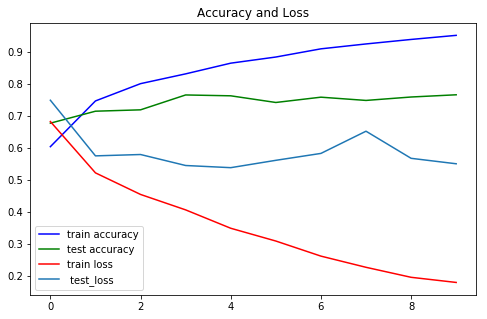

In [36]:
plt.figure(figsize=(8,5))

plt.plot(model.history.history['acc'], color='blue', label='train accuracy')
plt.plot(model.history.history['val_acc'], color='green', label='test accuracy')

plt.plot(model.history.history['loss'], color='red', label='train loss')
plt.plot(model.history.history['val_loss'], label=' test_loss')

plt.title("Accuracy and Loss")
plt.legend()

model.evaluate(X_test, y_test)


In [40]:
# model.save('RNN_multiclass_emotion.h5')

RNN_preds = model.predict_on_batch(X_test)

RNN_preds_df = pd.DataFrame({"pred_anger":RNN_preds[:,0], "pred_disgust":RNN_preds[:,1], "pred_fear":RNN_preds[:,2], "pred_joy":RNN_preds[:,3], "pred_sadness":RNN_preds[:,4], "pred_suprise":RNN_preds[:,5], "anger":y_test[:,0], "disgust":y_test[:,1], "fear": y_test[:,2], "joy": y_test[:,3], "sadness": y_test[:,4], "suprise": y_test[:,5]})


anger accuracy: 0.40384615384615385
anger precision: 0.7777777777777778
anger recall 0.7636363636363637
anger f1 0.7706422018348624


disgust accuracy: 0.2724358974358974
disgust precision: 0.6159420289855072
disgust recall 0.6692913385826772
disgust f1 0.6415094339622641


fear accuracy: 0.5256410256410257
fear precision: 0.8324873096446701
fear recall 0.8118811881188119
fear f1 0.8220551378446116


joy accuracy: 0.5352564102564102
joy precision: 0.7488789237668162
joy recall 0.8520408163265306
joy f1 0.7971360381861575


sadness accuracy: 0.5801282051282052
sadness precision: 0.8190045248868778
sadness recall 0.8701923076923077
sadness f1 0.8438228438228438


suprise accuracy: 0.8589743589743589
suprise precision: 0.8758169934640523
suprise recall 0.9781021897810219
suprise f1 0.9241379310344828




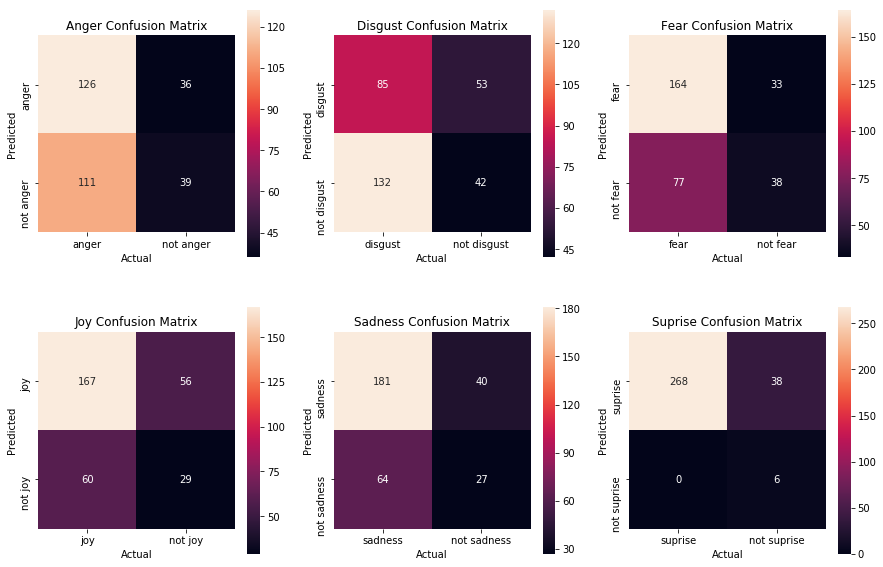

In [38]:
label_confusion_matrices(['anger', 'disgust', 'fear', 'joy', 'sadness', 'suprise'], RNN_preds_df, RNN=True)

In [39]:
suite_of_scores(y_test, RNN_preds>.5)


jaccard score micro: 0.694
hamming loss: 0.233
f1 macro: 0.8
